**Bibliotecas**

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

**Montar o google drive no Colab**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

**Importar arquivos de configuração do Kaglle**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabiobasson","key":"d71cbfdfd23379909173204eac74cf96"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### ** Download dos dados / descompactando os dados**

In [5]:
!kaggle datasets download phylake1337/fire-dataset

 98% 379M/387M [00:02<00:00, 147MB/s]
100% 387M/387M [00:02<00:00, 138MB/s]


In [6]:
!unzip -qq fire-dataset.zip

**Criando o Diretorio Df e unificando os dados dentro dele (não utilizado)**

In [6]:
! mkdir df
!cp -r fire_dataset/fire_images/* df
! cp -r fire_dataset/non_fire_images/* df

**Tentado dividir os dados em treino, validação e teste (sem sucesso)**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("df")
new_base_dir = pathlib.Path("new_fire")

def make_subset(subset_name, start_index, end_index):
    for category in ("fire","non_fire"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.png" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=1, end_index=300)
make_subset("validation", start_index=301, end_index=600)
make_subset("test", start_index=600, end_index=999)

FileNotFoundError: ignored

### Data Preprocessing

In [ ]:
#ignorar esse codigo

fire_dir = glob.glob('fire_dataset/fire_images/*.png')

In [ ]:
#ignorar esse codigo

import os, shutil, pathlib

original_dir = pathlib.Path("df")
#make_subset("train", start_index=1, end_index=300)
train_dir = os.path.join(original_dir)
validation_dir = os.path.join(original_dir)

## **This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.**

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [8]:
IMG_SHAPE = 256
BATCH_SIZE = 20

In [9]:
datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range = 40,
                            #width_shift_range = 0.2,
                            #height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True)

In [10]:
train_generator = datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory="fire_dataset",
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE),
                                               class_mode='binary')

Found 999 images belonging to 2 classes.


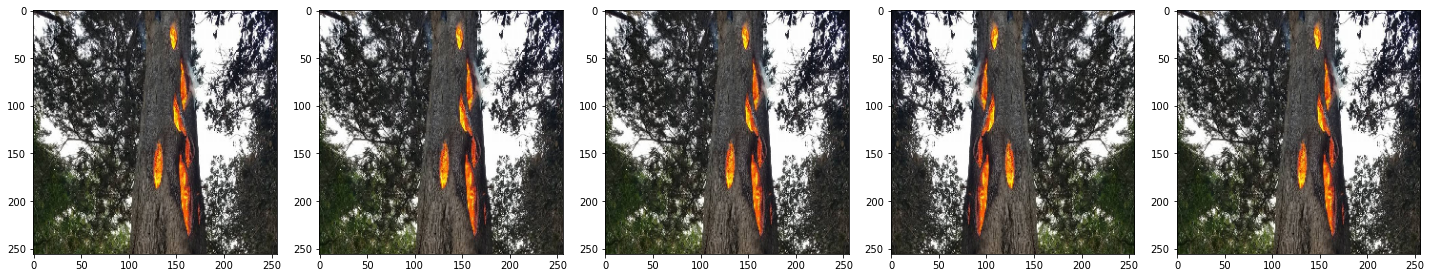

In [11]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
image_gen_val = ImageDataGenerator(rescale=1./255)

validation_generator = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory="fire_dataset",
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 999 images belonging to 2 classes.


In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

**Compilando o Modelo**

In [67]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['accuracy'])

In [68]:
model.summary()   

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 8, 8, 512)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 8,389,121
Trainable params: 8,389,121
Non-trainable params: 0
_________________________________________________________________


In [14]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        #restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        save_best_only=True,
    ),

]

In [17]:
history = model.fit(train_generator,
                               epochs=20,
                               #verbose=0,
                               callbacks=callbacks_list, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_data=validation_generator)

Epoch 1/20
50/50 [==============================] - 86s 1s/step - loss: 0.6361 - accuracy: 0.5926 - val_loss: 0.2886 - val_accuracy: 0.9279
Epoch 2/20
50/50 [==============================] - 58s 1s/step - loss: 0.3127 - accuracy: 0.7457 - val_loss: 0.2377 - val_accuracy: 0.8729
Epoch 3/20
50/50 [==============================] - 67s 1s/step - loss: 0.9695 - accuracy: 0.7017 - val_loss: 0.2382 - val_accuracy: 0.7017
Epoch 4/20
50/50 [==============================] - 68s 1s/step - loss: 0.2399 - accuracy: 0.5866 - val_loss: 0.1588 - val_accuracy: 0.2943
Epoch 5/20
50/50 [==============================] - 68s 1s/step - loss: 0.1733 - accuracy: 0.5385 - val_loss: 0.1490 - val_accuracy: 0.3664
Epoch 6/20
50/50 [==============================] - 56s 1s/step - loss: 0.2043 - accuracy: 0.3203 - val_loss: 0.1401 - val_accuracy: 0.5045
Epoch 7/20
50/50 [==============================] - 59s 1s/step - loss: 0.1658

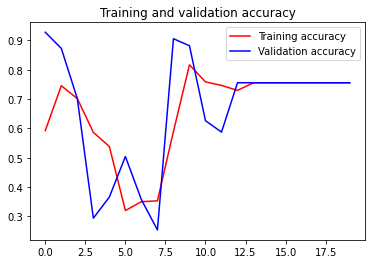

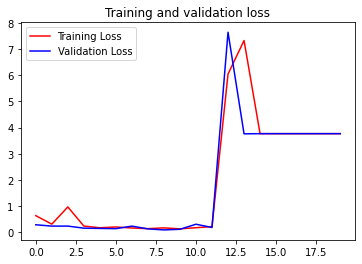

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
model = tf.keras.models.load_model("best_model.h5")

val_acc1 = model.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

50/50 [==============================] - 29s 579ms/step - loss: 0.2886 - accuracy: 0.9279
validation_accuracy: 0.9279279112815857


**the VGG16 model.**

In [15]:
conv_base = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))
conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [17]:
inputs = tf.keras.Input(shape=(256, 256, 3))
#x = datagen(inputs)
x = conv_base(inputs)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
modelvgg16 = tf.keras.Model(inputs, outputs)

modelvgg16.compile(optimizer ='rmsprop', 
                loss = 'mse', 
                metrics =['accuracy'])

callbacksvgg16 = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]


In [ ]:
history = modelvgg16.fit_generator(train_generator,
                         epochs=20,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=callbacksvgg16)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
19/50 [==========>...................] - ETA: 21:57 - loss: 0.2593 - accuracy: 0.7309

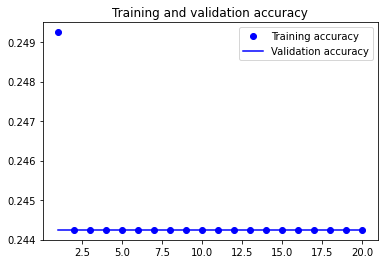

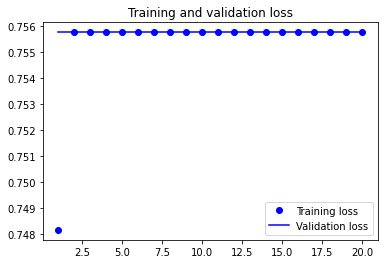

In [79]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**### InceptionV3**

In [22]:
Inception_V3 = InceptionV3(input_shape=(256,256,3),
                           include_top=False)
InceptionV3.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [23]:
Inception_V3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 2566, 3 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 127, 1282, 32 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 1282, 32 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 1282, 32 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [24]:
Inception_V3.input

<KerasTensor: shape=(None, 256, 2566, 3) dtype=float32 (created by layer 'input_3')>

In [ ]:
## ignorar esse codigo

from keras import models
from keras import layers

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu', input_shape=(256,256,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

#x = layers.Flatten()(inception_v3.output)
#x = layers.BatchNormalization()(x)
#x = layers.Dense(1024,activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
#x = layers.Dense(1,activation='sigmoid')(x)           

#model1 = Model(inception_v3.input, x) 

AttributeError: ignored

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

model1.compile(optimizer = Adam(learning_rate=0.0001,decay=1e-5), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model1.fit(train_generator,
                               epochs=20,
                               verbose=1,
                               validation_data=validation_generator)

Epoch 1/20
50/50 [==============================] - 205s 4s/step - loss: 1.1253 - acc: 0.5305 - val_loss: 0.3023 - val_acc: 0.7558
Epoch 2/20
50/50 [==============================] - 202s 4s/step - loss: 0.2721 - acc: 0.3504 - val_loss: 0.1697 - val_acc: 0.1862
Epoch 3/20
50/50 [==============================] - 202s 4s/step - loss: 0.3161 - acc: 0.2893 - val_loss: 0.3694 - val_acc: 0.0751
Epoch 4/20
 5/50 [==>...........................] - ETA: 2:09 - loss: 0.3144 - acc: 0.2300

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc1= model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc1))

### EfficientNet B0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
efficientnet_b0 = EfficientNetB0(include_top=False,
                             weights="imagenet",
                             input_shape=(256,256,3))
efficientnet_b0.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b0.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model2 = Model(efficientnet_b0.input, x) 

model2.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model2.fit_generator(train_generator,
                               epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc2 = model2.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc2))

### EfficientNet B7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7

In [ ]:
efficientnet_b7 = EfficientNetB7(include_top=False,
                                 weights="imagenet",
                                 input_shape=(256,256,3))
efficientnet_b7.trainable = False

In [ ]:
x = layers.Flatten()(efficientnet_b7.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1,activation='sigmoid')(x)           

model3 = Model(efficientnet_b7.input, x) 

model3.compile(optimizer = Adam(lr=0.0001), 
               loss = 'binary_crossentropy', 
               metrics =['acc'])

In [ ]:
history = model3.fit_generator(train_generator,epochs=50,
                               verbose=0,
                               validation_data=validation_generator)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
val_acc3 = model3.evaluate(validation_generator)[1]
print("validation_accuracy: " + str(val_acc3))

### Model Comparison

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [val_acc1,val_acc2,val_acc3]
model = ['InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()